##### 1. INSTALL AND IMPORT DEPENDENCIES

In [65]:
import tensorflow as tf
import cv2
import json
import shutil
import os
from pathlib import Path
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import labelme
import time
from sklearn.model_selection import train_test_split
import wget

In [121]:
PATH = {
    'WORKSPACE_PATH':Path('workspace'),
    'IMAGE_PATH': Path('workspace','images'),
    'COLLECTED_IMAGE_PATH': Path('workspace','images','collectedImages'),
    'TRAIN_IMAGE_PATH': Path('workspace','images','train'),
    'TEST_IMAGE_PATH': Path('workspace','images','test'),
    'ANNOTATION_PATH': Path('workspace','annotation'),
    'PRETRAINED_MODEL': Path('workspace','pre-trained_model'),
    'APIMODEL_PATH': os.path.join('C:\\Users\\bkj\\Documents\\GitHub\\AI PROJECTS\\computer vision\\.tfod-dependencies\\model'),
    'MODEL_PATH': os.path.join('workspace','models'),
    'CHECKPOINT_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME,'export'),
    'TFJS_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME,'tfjsexport'),
    'TFLITE_PATH': os.path.join('workspace','models',CUSTOM_MODEL_NAME,'tfliteexport'),
}

file = {
    'LABELMAP_PATH': os.path.join(str(PATH['ANNOTATION_PATH']),'labelmap.pbtxt'),
    'TFRECORD_PATH': os.path.join('C:\\Users\\bkj\\Documents\\GitHub\\AI PROJECTS\\computer vision\\.tfod-dependencies\\scripts','generate_tfrecord_labelme.py')
}

for x in PATH:
    os.makedirs(str(PATH[x]),exist_ok=True)

##### 2. COLLECT AND LABEL IMAGES

In [105]:
LABELS = ['nomask','mask']

In [16]:
LABELS = ['nomask','mask']
numberOfImages = 10

cap = cv2.VideoCapture(0)
for label in LABELS:
    print(f'Collecting images for {label}')
    for i in range(numberOfImages):
        ret,frame = cap.read()
        image_filename = os.path.join(str(PATH['IMAGE_PATH']),f'{label}_{uuid.uuid1()}.jpg')
        cv2.imwrite(image_filename,frame)
        cv2.imshow('frame',frame)
        time.sleep(1)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [17]:
! labelme

##### 3. SPLIT TO TRAIN AND TEST FOLDERS

In [21]:
image_files = [file for file in Path(PATH['IMAGE_PATH']).glob('*.jpg')]

train_files,test_files = train_test_split(image_files,test_size=0.2,random_state=42)

for file in train_files:
    image  = str(file)
    label = str(file.with_suffix('.json'))
    shutil.copy(image,PATH['TRAIN_IMAGE_PATH'])
    shutil.copy(label,PATH['TRAIN_IMAGE_PATH'])

for file in test_files:
    image  = str(file)
    label = str(file.with_suffix('.json'))
    shutil.copy(image,PATH['TEST_IMAGE_PATH'])
    shutil.copy(label,PATH['TEST_IMAGE_PATH'])


(-0.5, 639.5, 479.5, -0.5)

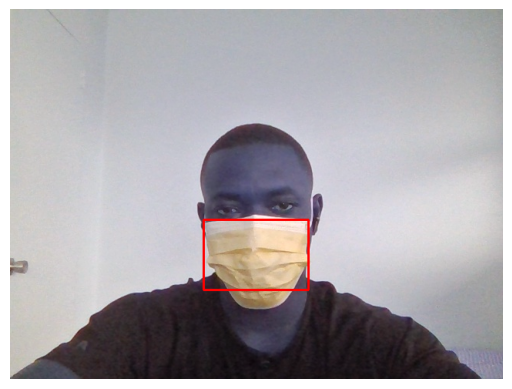

In [29]:
image_num = cv2.imread(image)

with open(label,'r') as f:
    labels = json.load(f)

bbox = np.array(labels['shapes'][0]['points']).ravel()
class_label = labels['shapes'][0]['label']

cv2.rectangle(image_num,
              bbox[:2].astype(int),
              bbox[2:].astype(int),
              (255,0,0),2)

plt.imshow(image_num)
plt.axis('off')

##### 4. CREATE A LABEL MAP

In [43]:
LABEL_MAP = [{'name':'mask','id':1},{'name':'nomask','id':2}]

with open(file['LABELMAP_PATH'],'w') as f:
    for label in LABEL_MAP:
        f.write('item { \n')
        f.write('\tname: \'{}\'\n'.format(label['name']))
        f.write('\tid: {}\n'.format(label['id']))
        f.write('} \n')

##### 5. GET TFRECORD FILES FOR TRAIN AND TEST

In [60]:
!python "{file['TFRECORD_PATH']}" -j {str(PATH['TRAIN_IMAGE_PATH'])}  -i {str(PATH['TRAIN_IMAGE_PATH'])} -l {file['LABELMAP_PATH']} -o {os.path.join(PATH['ANNOTATION_PATH'],'train.record')}
!python "{file['TFRECORD_PATH']}" -j {str(PATH['TEST_IMAGE_PATH'])} -i {str(PATH['TEST_IMAGE_PATH'])} -l {file['LABELMAP_PATH']} -o {os.path.join(PATH['ANNOTATION_PATH'],'test.record')}

Successfully created the TFRecord file: workspace\annotation\train.record
Successfully created the TFRecord file: workspace\annotation\test.record


##### 6. GET PRETRAINED MODEL

In [64]:
CUSTOM_MODEL_NAME =  'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

In [81]:
os.makedirs(os.path.join(str(PATH['PRETRAINED_MODEL']),CUSTOM_MODEL_NAME),exist_ok=True)
wget.download(PRETRAINED_MODEL_URL)
!move {PRETRAINED_MODEL_NAME} {os.path.join(str(PATH['PRETRAINED_MODEL']),CUSTOM_MODEL_NAME)}
!cd {os.path.join(str(PATH['PRETRAINED_MODEL']),CUSTOM_MODEL_NAME)} && tar -zxvf {PRETRAINED_MODEL_NAME}

        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [88]:
VERIFICATION_SCRIPT = os.path.join(PATH['APIMODEL_PATH'],'research','object_detection','builders','model_builder_tf2_test.py')
!python "{VERIFICATION_SCRIPT}"

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Running tests under Python 3.10.2: c:\Users\bkj\AppData\Local\Programs\Python\Python310\python.exe


[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0911 18:27:51.190465  1500 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchNormalization` with parameter `synchronized` set to True.
W0911 18:27:51.222650  1500 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchNormalization` with parameter `synchronized` set to True.
W0911 18:27:51.234155  1500 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and will be removed in a future release. Please use `tf.keras.layers.BatchNormalization` with parameter `synchronized` set to True.
W0911 18:27:51.239152  1500 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprecated and 

##### 7. COPY MODEL CONFIG TO TRAINING FOLDER

In [100]:
!copy {file['PIPELING_PATH']} {file['CHECKPOINT_PATH'] }

        1 file(s) copied.


In [133]:
file['PIPELING_PATH'] = os.path.join(str(PATH['PRETRAINED_MODEL']),'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','pipeline.config')
file['CHECKPOINT_PATH'] = os.path.join(str(PATH['PRETRAINED_MODEL']),CUSTOM_MODEL_NAME,'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','checkpoint')

##### 8. UPDATE CONFIG FOR TRANSFER LEARNING

In [101]:
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [102]:
config = config_util.get_configs_from_pipeline_file(file['PIPELING_PATH'])
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [103]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(file['PIPELING_PATH'],'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str,pipeline_config)

In [136]:
pipeline_config.model.ssd.num_classes = len(LABELS)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(PATH['PRETRAINED_MODEL'],'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8','checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= file['LABELMAP_PATH']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(PATH['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = file['LABELMAP_PATH']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(PATH['ANNOTATION_PATH'], 'test.record')]

In [137]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(file['PIPELING_PATH'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

##### 9. TRAIN THE MODEL

In [ ]:
TRAINING_SCRIPT = os.path.join(PATH['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

# command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, PATH['CHECKPOINT_PATH'],file['PIPELING_PATH'])

!python "{TRAINING_SCRIPT}" --model_dir={PATH['CHECKPOINT_PATH']} --pipeline_config_path={file['PIPELING_PATH']} --num_train_steps=2000

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
W0911 19:20:42.814325 18356 cross_device_ops.py:1387] There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0911 19:20:42.878113 18356 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0911 19:20:42.886506 1


Instructions for updating:
rename to distribute_datasets_from_function
INFO:tensorflow:Reading unweighted datasets: ['workspace\\annotation\\train.record']
I0911 19:20:42.943820 18356 dataset_builder.py:162] Reading unweighted datasets: ['workspace\\annotation\\train.record']
INFO:tensorflow:Reading record datasets for input file: ['workspace\\annotation\\train.record']
I0911 19:20:42.944821 18356 dataset_builder.py:79] Reading record datasets for input file: ['workspace\\annotation\\train.record']
INFO:tensorflow:Number of filenames to read: 1
I0911 19:20:42.944821 18356 dataset_builder.py:80] Number of filenames to read: 1
W0911 19:20:42.944821 18356 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
W0911 19:20:42.964121 18356 deprecation.

##### 10. EVALUATE THE MODEL

In [139]:
!python "{TRAINING_SCRIPT}" --model_dir={PATH['CHECKPOINT_PATH']} --pipeline_config_path={file['PIPELING_PATH']} --checkpoint_dir = {PATH['CHECKPOINT_PATH']}

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
W0911 20:24:10.032384 23208 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0911 20:24:10.032384 23208 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0911 20:24:10.032384 23208 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting ev

##### 11. LOAD TRAIN MODEL FROM CHECKPOINT

In [140]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

c:\Users\bkj\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [145]:
# load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(file['PIPELING_PATH'])
detection_model = model_builder.build(model_config=configs['model'],is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH['CHECKPOINT_PATH'],'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image,shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image,shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

##### 12. DETECT FROM AN IMAGE

In [147]:
category_index = label_map_util.create_category_index_from_labelmap(file['LABELMAP_PATH'])
IMAGEFILE_PATH = os.path.join(PATH['IMAGE_PATH'],'test','mask_a7b700d4-50e2-11ee-9339-80e82c11f1a6.jpg')
IMAGEFILE_PATH

'workspace\\images\\test\\mask_a7b700d4-50e2-11ee-9339-80e82c11f1a6.jpg'

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break